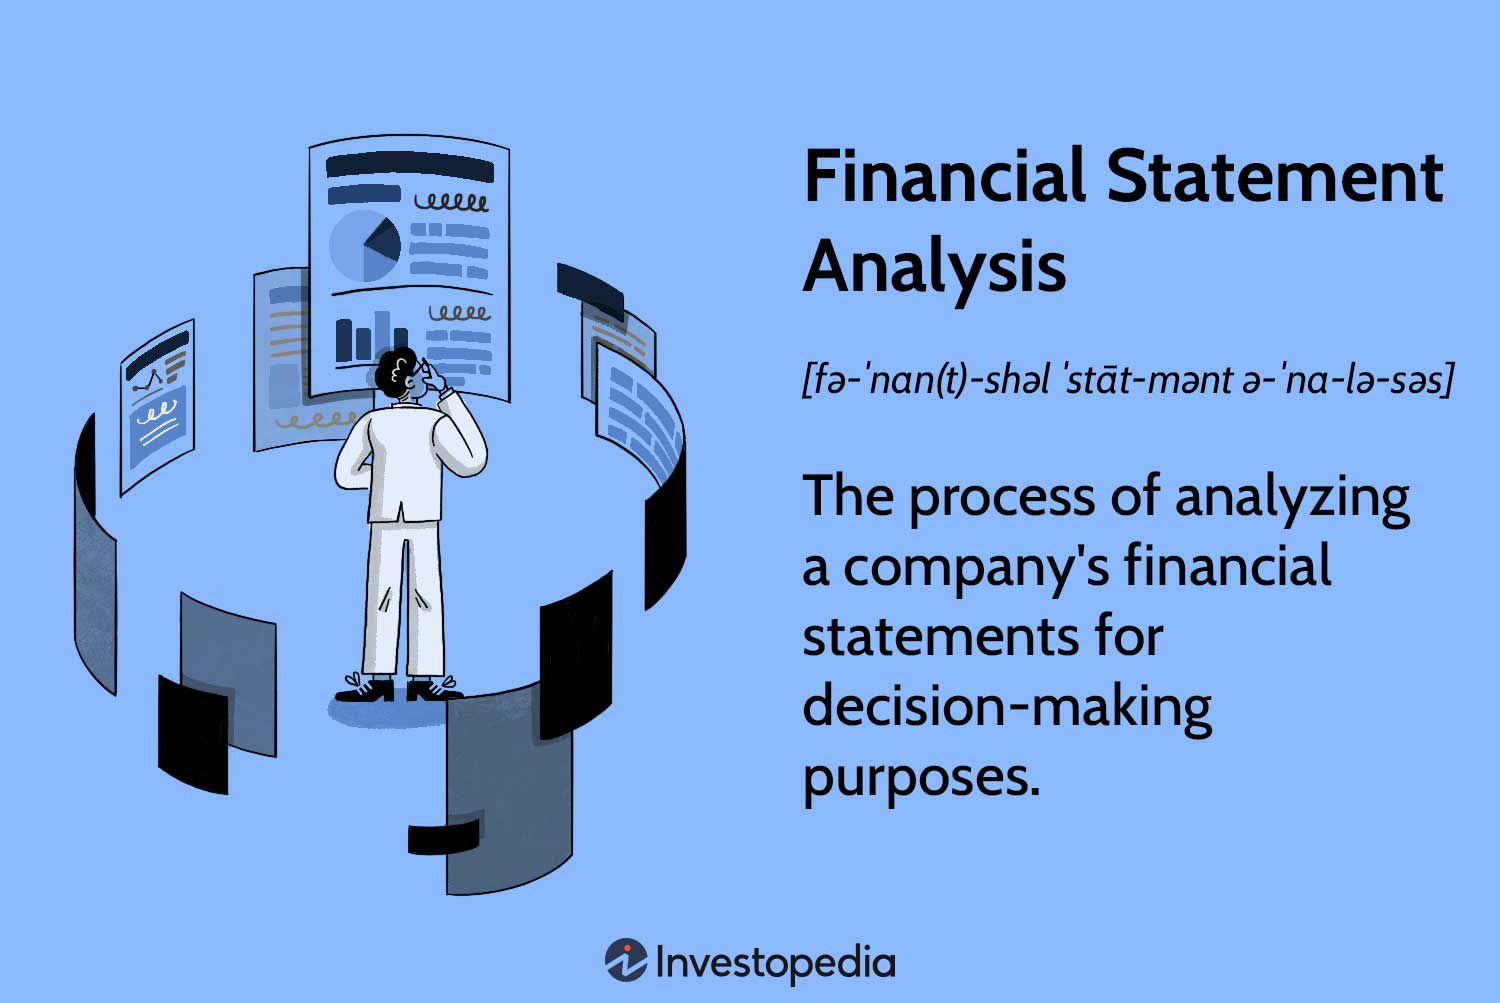

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **IMPORTING THE RELEVENT LIBRARIES**

In [ ]:
import pandas as pd
import numpy as np

!pip install transformers
!pip install transformers datasets
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from sklearn.metrics import accuracy_score, f1_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification

# **IMPORTING THE DATA**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/MY_DATASETS/data.csv', encoding='ISO-8859-1')

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"For the last quarter of 2010 , Componenta 's n...",positive
2,$SPY wouldn't be surprised to see a green close,positive
3,Kone 's net sales rose by some 14 % year-on-ye...,positive
4,Circulation revenue has increased by 5 % in Fi...,positive


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7239 entries, 0 to 7238
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   6248 non-null   object
 1   Sentiment  6248 non-null   object
dtypes: object(2)
memory usage: 113.2+ KB


In [ ]:
unique_sentiments = df.Sentiment.unique()
unique_sentiments

array(['positive', 'neutral', 'negative', 'Negative'], dtype=object)

In [ ]:
df.dropna(inplace = True)

In [ ]:
# Find the maximum word count in sentences in the 'Sentence' column
max_word_count = df['Sentence'].apply(lambda x: len(x.split())).max()
print(f"Maximum sentence word count: {max_word_count} words")


Maximum sentence word count: 81 words


In [ ]:
df['Sentiment'] = df['Sentiment'].replace({'Negative': 'negative'})

unique_sentiments = df['Sentiment'].unique()
df['Sentiment'].value_counts()

,count
Sentiment,
neutral,2139
negative,2076
positive,2033


In [ ]:
print(df.isnull().sum())
print(df.duplicated().sum())

Sentence     0
Sentiment    0
dtype: int64
32


In [ ]:
df.dropna(inplace = True)

In [ ]:
sentiment_mapping = {'positive': 0, 'neutral': 1, 'negative': 2}

df['Sentiment'] = df['Sentiment'].map(sentiment_mapping)

# **LOADING THE MODEL**

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/933 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

# **SPLITTING THE DATA**

In [ ]:
train_data, val_data = train_test_split(df, test_size=0.2, stratify=df['Sentiment'], random_state=42)

train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)
dataset = DatasetDict({'train': train_dataset, 'validation': val_dataset})

# **TOKENIZING AND PREPROCESSING**

In [ ]:
def preprocess(data):
    tokenized_inputs = tokenizer(data['Sentence'], padding='max_length', truncation=True, max_length=128)
    tokenized_inputs['labels'] = [int(label) for label in data['Sentiment']]
    return tokenized_inputs

def compute_metrics(pred):
    logits, labels = pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="weighted")

    return {"accuracy": accuracy, "f1": f1}

tokenized_dataset = dataset.map(preprocess, batched=True)

Map:   0%|          | 0/4998 [00:00<?, ? examples/s]

Map:   0%|          | 0/1250 [00:00<?, ? examples/s]

# **TRAINING AND FINE-TUNING THE MODEL**

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.1
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:


# training_args = TrainingArguments(
#     output_dir='./results',
#     eval_strategy="epoch",  # Replaced deprecated evaluation_strategy with eval_strategy
#     save_strategy="epoch",  # Set save_strategy to match eval_strategy
#     load_best_model_at_end=True,
#     learning_rate=3e-5,
#     per_device_train_batch_size=32,
#     per_device_eval_batch_size=16,
#     num_train_epochs=3,
#     weight_decay=0.01
# )

# training_args = TrainingArguments(
#     output_dir='./results',
#     eval_strategy="epoch",
#     save_strategy="epoch",
#     learning_rate=1e-5,  # Adjusted for stability
#     per_device_train_batch_size=32,
#     per_device_eval_batch_size=32,
#     num_train_epochs=5,  # More epochs for better learning
#     weight_decay=0.1,
#     logging_dir='./logs',
#     logging_steps=10,
#     save_total_limit=2,
#     load_best_model_at_end=True,
# )

# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=tokenized_dataset['train'],
#     eval_dataset=tokenized_dataset['validation'],
#     compute_metrics=compute_metrics
# )

In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.315497,0.858400,0.857485
2,No log,0.302621,0.867200,0.865359
3,No log,0.306698,0.868800,0.868629
4,0.398100,0.364502,0.864800,0.862929
5,0.398100,0.364177,0.859200,0.858869


TrainOutput(global_step=785, training_loss=0.314033406251555, metrics={'train_runtime': 321.5451, 'train_samples_per_second': 77.718, 'train_steps_per_second': 2.441, 'total_flos': 827604831997440.0, 'train_loss': 0.314033406251555, 'epoch': 5.0})

# **SAVING THE FINE-TUNED MODEL & TOKENIZER**

In [ ]:
# model.save_pretrained("./fine_tuned_model")
# tokenizer.save_pretrained("./fine_tuned_model")

In [ ]:
# !zip -r fine_tuned_model.zip ./fine_tuned_model
# from google.colab import files
# files.download("fine_tuned_model.zip")

To use the pre-built final model, download this


In [ ]:
https://drive.google.com/file/d/1gV8ApuFgM10sxlS8WDuDh_FOqalodD_p/view?usp=sharing